# Homework 8

In this homework, you will be training a sequence-to-sequence model. Unfortunately, these models can be somewhat expensive to train, and the free GPU/TPU from colab is not sufficient to train a sequence-to-sequence model on a terribly large/difficult task. So, you will be translating short phrases from English to French using a small dataset comes from [Tatoeba](tatoeba.org).

This homework contains example pytorch code that mainly comes from the textbook. There is an analogous mxnet example in the textbook you can use instead.

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-en.git matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-en.git to /tmp/pip-req-build-8sqk48ma
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-8sqk48ma
  Resolved https://github.com/d2l-ai/d2l-en.git to commit f37303e611200cb12e5e04ac5f784e0e37ae3c97
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00
  Created wheel for d2l: filename=d2l-1.

In [2]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import time
import matplotlib.pyplot as plt

# Example sequence-to-sequence model implementation

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['sois', 'calme', '.'], bleu,0.492
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


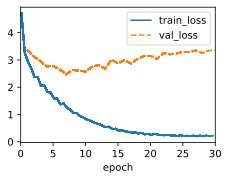

In [3]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                    save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

# Problems


| | Model 1      | Model 2 | Model 3     | 
| :--- | :---        |    :----   |          :--- |
| Final Loss:| 3.1248     | 4.0104       | 3.5872   | 
| Training Time:| 30.60s   | 33.08s        | 18.72s     | 

1. In the example, sequence-to-sequence learning is enabled by initializing the decoder state with the final encoder state and by concatenating the final encoder state with the embeddings used as input to the decoder. Modify the code so that the final encoder state is *only* used to initialize the decoder, *not* concatenated with the decoder embeddings. Does this change the loss and/or the predictions of the model? Why do you think this is?

**Remove the context from decoder embeddings**

In [3]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Change input size to embed_size instead of embed_size + num_hiddens
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # Remove the concatenation of context and embeddings
        outputs, hidden_state = self.rnn(embs, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        self.train_losses = []
        self.val_losses = []
        self.epoch_train_losses = []
        self.epoch_val_losses = []

    def training_step(self, batch):
        Y_hat = self(*batch[:-1])
        loss = self.loss(Y_hat, batch[-1])
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        loss = self.loss(Y_hat, batch[-1])
        self.val_losses.append(loss.item())
        return loss

    def on_epoch_end(self):
        avg_train_loss = sum(self.train_losses) / len(self.train_losses)
        avg_val_loss = sum(self.val_losses) / len(self.val_losses)
        self.epoch_train_losses.append(avg_train_loss)
        self.epoch_val_losses.append(avg_val_loss)
        print(f'Epoch {len(self.epoch_train_losses)}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')
        self.train_losses = []
        self.val_losses = []

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                    save_attention_weights=False, sampling_temperature=1.0):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            # Apply temperature for sampling
            Y = Y / sampling_temperature
            # Sample the next token from the predicted distribution
            next_token = torch.multinomial(F.softmax(Y.squeeze(), dim=-1), 1)
            outputs.append(next_token)
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

**Training the model**

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1: Train Loss=4.0017, Val Loss=3.3201
Epoch 2: Train Loss=2.6507, Val Loss=2.9452
Epoch 3: Train Loss=2.2159, Val Loss=2.7703
Epoch 4: Train Loss=1.9227, Val Loss=2.6048
Epoch 5: Train Loss=1.6748, Val Loss=2.6249
Epoch 6: Train Loss=1.4497, Val Loss=2.4836
Epoch 7: Train Loss=1.2452, Val Loss=2.4692
Epoch 8: Train Loss=1.0745, Val Loss=2.5033
Epoch 9: Train Loss=0.9241, Val Loss=2.3977
Epoch 10: Train Loss=0.8024, Val Loss=2.5597
Epoch 11: Train Loss=0.6952, Val Loss=2.5132
Epoch 12: Train Loss=0.6079, Val Loss=2.5351
Epoch 13: Train Loss=0.5327, Val Loss=2.7145
Epoch 14: Train Loss=0.4670, Val Loss=2.6643
Epoch 15: Train Loss=0.4160, Val Loss=2.6898
Epoch 16: Train Loss=0.3721, Val Loss=2.8046
Epoch 17: Train Loss=0.3419, Val Loss=2.8402
Epoch 18: Train Loss=0.3140, Val Loss=2.8840
Epoch 19: Train Loss=0.2966, Val Loss=2.8027
Epoch 20: Train Loss=0.2705, Val Loss=2.9379
Epoch 21: Train Loss=0.2585, Val Loss=2.9163
Epoch 22: Train Loss=0.2470, Val Loss=2.8892
Epoch 23: Train Los

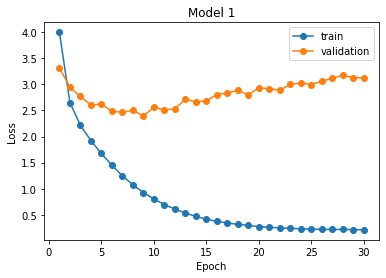

In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

class CustomTrainer:
    def __init__(self, model, data, max_epochs, gradient_clip_val, num_gpus):
        self.model = model
        self.data = data
        self.max_epochs = max_epochs
        self.gradient_clip_val = gradient_clip_val
        self.num_gpus = num_gpus
        self.model.trainer = self
        self.epoch = 0
        self.num_val_batches = len(data.val_dataloader())
        self.num_train_batches = len(data.train_dataloader())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=model.lr)

    def fit_epoch(self):
      train_losses = []
      val_losses = []
    
      self.model.train()
      for train_batch_idx, batch in enumerate(self.data.train_dataloader()):
          self.train_batch_idx = train_batch_idx
          loss = self.model.training_step(batch)
          train_losses.append(loss.item())
          self.optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip_val)
          self.optimizer.step()

      self.model.eval()
      for val_batch_idx, batch in enumerate(self.data.val_dataloader()):
          self.val_batch_idx = val_batch_idx
          with torch.no_grad():
              loss = self.model.validation_step(batch)
              val_losses.append(loss.item())

      self.model.on_epoch_end()
    
      return train_losses, val_losses

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

custom_trainer = CustomTrainer(model, data, max_epochs=30, gradient_clip_val=1, num_gpus=1)

start_time = time.time()
for epoch in range(30):
    custom_trainer.epoch = epoch
    custom_trainer.fit_epoch()
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Plot the losses after the training loop is finished
plt.plot(range(1, len(model.epoch_train_losses) + 1), model.epoch_train_losses, label='train', marker='o')
plt.plot(range(1, len(model.epoch_val_losses) + 1), model.epoch_val_losses, label='validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1')
plt.legend()
plt.show()

**Predictions**

In [5]:
model = model.to(d2l.try_gpu())  # Move the model to GPU
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['fais', 'un', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


We can observe that the final validation loss of the current model increases after removing the concatenation of the final encoder state with the decoder embeddings. Simultaneously, the BLEU score for the poorly predicted sentence (he's calm.) drops to 0, indicating worse performance compared to the original model. The initial implementation concatenated the final encoder state with the decoder embeddings, allowing the decoder to continuously access the encoded information. After removing this concatenation, the decoder only receives the encoded information from the input sequence during the initialization of its hidden state. As a result, when faced with a challenging sentence, the model's performance is not as good as the original method.

2. The prediction function above uses greedy sampling (choosing the most probable token at each time step). Change it so that it instead samples randomly at each time step according to the predicted distribution. Generate the predictions a few times for the example English sentences provided. Do they ever change? Why do you think they do or don't change? Hint: You will need to implement a categorical sampler. One way to do this is with [torch.multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html).

**Change the prediction step**

In [3]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        self.train_losses = []
        self.val_losses = []
        self.epoch_train_losses = []
        self.epoch_val_losses = []

    def training_step(self, batch):
        Y_hat = self(*batch[:-1])
        loss = self.loss(Y_hat, batch[-1])
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        loss = self.loss(Y_hat, batch[-1])
        self.val_losses.append(loss.item())
        return loss

    def on_epoch_end(self):
        avg_train_loss = sum(self.train_losses) / len(self.train_losses)
        avg_val_loss = sum(self.val_losses) / len(self.val_losses)
        self.epoch_train_losses.append(avg_train_loss)
        self.epoch_val_losses.append(avg_val_loss)
        print(f'Epoch {len(self.epoch_train_losses)}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')
        self.train_losses = []
        self.val_losses = []

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                    save_attention_weights=False, sampling_temperature=1.0):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            # Apply temperature for sampling
            Y = Y / sampling_temperature
            # Sample the next token from the predicted distribution
            next_token = torch.multinomial(F.softmax(Y.squeeze(), dim=-1), 1)
            outputs.append(next_token)
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

**Training the model**

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1: Train Loss=4.0762, Val Loss=3.5018
Epoch 2: Train Loss=2.7682, Val Loss=2.9703
Epoch 3: Train Loss=2.3492, Val Loss=2.9320
Epoch 4: Train Loss=2.0551, Val Loss=2.6875
Epoch 5: Train Loss=1.7898, Val Loss=2.6947
Epoch 6: Train Loss=1.5520, Val Loss=2.5865
Epoch 7: Train Loss=1.3410, Val Loss=2.6777
Epoch 8: Train Loss=1.1684, Val Loss=2.5425
Epoch 9: Train Loss=1.0006, Val Loss=2.7242
Epoch 10: Train Loss=0.8749, Val Loss=2.8119
Epoch 11: Train Loss=0.7509, Val Loss=2.7976
Epoch 12: Train Loss=0.6421, Val Loss=2.8659
Epoch 13: Train Loss=0.5565, Val Loss=2.9874
Epoch 14: Train Loss=0.4911, Val Loss=3.1113
Epoch 15: Train Loss=0.4347, Val Loss=3.1813
Epoch 16: Train Loss=0.3932, Val Loss=3.4923
Epoch 17: Train Loss=0.3533, Val Loss=3.2885
Epoch 18: Train Loss=0.3273, Val Loss=3.3374
Epoch 19: Train Loss=0.2958, Val Loss=3.3885
Epoch 20: Train Loss=0.2782, Val Loss=3.4940
Epoch 21: Train Loss=0.2580, Val Loss=3.5294
Epoch 22: Train Loss=0.2461, Val Loss=3.5791
Epoch 23: Train Los

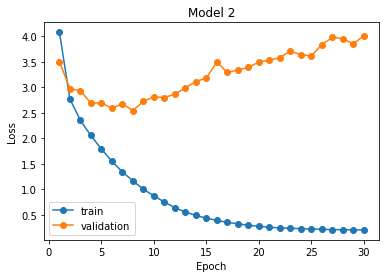

In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

class CustomTrainer:
    def __init__(self, model, data, max_epochs, gradient_clip_val, num_gpus):
        self.model = model
        self.data = data
        self.max_epochs = max_epochs
        self.gradient_clip_val = gradient_clip_val
        self.num_gpus = num_gpus
        self.model.trainer = self
        self.epoch = 0
        self.num_val_batches = len(data.val_dataloader())
        self.num_train_batches = len(data.train_dataloader())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=model.lr)

    def fit_epoch(self):
      train_losses = []
      val_losses = []
    
      self.model.train()
      for train_batch_idx, batch in enumerate(self.data.train_dataloader()):
          self.train_batch_idx = train_batch_idx
          loss = self.model.training_step(batch)
          train_losses.append(loss.item())
          self.optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip_val)
          self.optimizer.step()

      self.model.eval()
      for val_batch_idx, batch in enumerate(self.data.val_dataloader()):
          self.val_batch_idx = val_batch_idx
          with torch.no_grad():
              loss = self.model.validation_step(batch)
              val_losses.append(loss.item())

      self.model.on_epoch_end()
    
      return train_losses, val_losses

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

custom_trainer = CustomTrainer(model, data, max_epochs=30, gradient_clip_val=1, num_gpus=1)

start_time = time.time()
for epoch in range(30):
    custom_trainer.epoch = epoch
    custom_trainer.fit_epoch()
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Plot the losses after the training loop is finished
plt.plot(range(1, len(model.epoch_train_losses) + 1), model.epoch_train_losses, label='train', marker='o')
plt.plot(range(1, len(model.epoch_val_losses) + 1), model.epoch_val_losses, label='validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2')
plt.legend()
plt.show()

**Predictions**

In [5]:
model = model.to(d2l.try_gpu())  # Move the model to GPU
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['pars', '!'], bleu,0.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ["c'est", '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Compared to the original sequence-to-sequence model implementation, we observe that the validation loss for the random sampling prediction method increases as well. Additionally, the prediction score (BLEU) for the provided sentence "go." and "he's calm." also drop to 0. When we change the decoding strategy from the original greedy approach to random sampling at each time step based on the predicted distribution, it introduces a level of uncertainty or randomness in the generated output. Although this may lead to a higher validation loss and lower BLEU scores, random sampling can provide more diverse outputs, which can be beneficial in certain applications.

3. In class, we discussed deep RNNs, which consist of stacks of RNN layers. The example code has two GRU layers in the encoder and two GRU layers in the decoder. Change it to only have a single layer in the encoder and a single layer in the decoder. Is training faster or slower? Is the final loss higher or lower?

**Model**

In [3]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
        self.train_losses = []
        self.val_losses = []
        self.epoch_train_losses = []
        self.epoch_val_losses = []

    def training_step(self, batch):
        Y_hat = self(*batch[:-1])
        loss = self.loss(Y_hat, batch[-1])
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        loss = self.loss(Y_hat, batch[-1])
        self.val_losses.append(loss.item())
        return loss

    def on_epoch_end(self):
        avg_train_loss = sum(self.train_losses) / len(self.train_losses)
        avg_val_loss = sum(self.val_losses) / len(self.val_losses)
        self.epoch_train_losses.append(avg_train_loss)
        self.epoch_val_losses.append(avg_val_loss)
        print(f'Epoch {len(self.epoch_train_losses)}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')
        self.train_losses = []
        self.val_losses = []

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()

    def predict_step(self, batch, device, num_steps,
                    save_attention_weights=False, sampling_temperature=1.0):
        batch = [a.to(device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            # Apply temperature for sampling
            Y = Y / sampling_temperature
            # Sample the next token from the predicted distribution
            next_token = torch.multinomial(F.softmax(Y.squeeze(), dim=-1), 1)
            outputs.append(next_token)
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights

def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

**One layer**

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1: Train Loss=3.7081, Val Loss=3.0123
Epoch 2: Train Loss=2.4305, Val Loss=2.8016
Epoch 3: Train Loss=2.0683, Val Loss=2.7000
Epoch 4: Train Loss=1.7755, Val Loss=2.5558
Epoch 5: Train Loss=1.5288, Val Loss=2.5261
Epoch 6: Train Loss=1.3124, Val Loss=2.5925
Epoch 7: Train Loss=1.1321, Val Loss=2.5520
Epoch 8: Train Loss=0.9859, Val Loss=2.6079
Epoch 9: Train Loss=0.8685, Val Loss=2.6776
Epoch 10: Train Loss=0.7532, Val Loss=2.6611
Epoch 11: Train Loss=0.6606, Val Loss=2.8330
Epoch 12: Train Loss=0.5916, Val Loss=2.8338
Epoch 13: Train Loss=0.5189, Val Loss=2.9886
Epoch 14: Train Loss=0.4617, Val Loss=2.9054
Epoch 15: Train Loss=0.4149, Val Loss=3.0878
Epoch 16: Train Loss=0.3701, Val Loss=3.0880
Epoch 17: Train Loss=0.3363, Val Loss=3.1632
Epoch 18: Train Loss=0.3089, Val Loss=3.1168
Epoch 19: Train Loss=0.2908, Val Loss=3.2504
Epoch 20: Train Loss=0.2688, Val Loss=3.2020
Epoch 21: Train Loss=0.2608, Val Loss=3.4045
Epoch 22: Train Loss=0.2454, Val Loss=3.3426
Epoch 23: Train Los

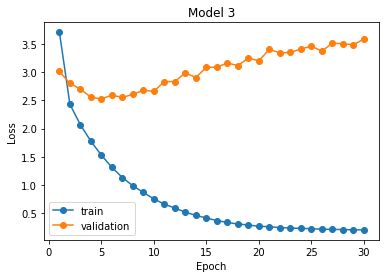

In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 1
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

class CustomTrainer:
    def __init__(self, model, data, max_epochs, gradient_clip_val, num_gpus):
        self.model = model
        self.data = data
        self.max_epochs = max_epochs
        self.gradient_clip_val = gradient_clip_val
        self.num_gpus = num_gpus
        self.model.trainer = self
        self.epoch = 0
        self.num_val_batches = len(data.val_dataloader())
        self.num_train_batches = len(data.train_dataloader())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=model.lr)

    def fit_epoch(self):
      train_losses = []
      val_losses = []
    
      self.model.train()
      for train_batch_idx, batch in enumerate(self.data.train_dataloader()):
          self.train_batch_idx = train_batch_idx
          loss = self.model.training_step(batch)
          train_losses.append(loss.item())
          self.optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip_val)
          self.optimizer.step()

      self.model.eval()
      for val_batch_idx, batch in enumerate(self.data.val_dataloader()):
          self.val_batch_idx = val_batch_idx
          with torch.no_grad():
              loss = self.model.validation_step(batch)
              val_losses.append(loss.item())

      self.model.on_epoch_end()
    
      return train_losses, val_losses

data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 1, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

custom_trainer = CustomTrainer(model, data, max_epochs=30, gradient_clip_val=1, num_gpus=1)

start_time = time.time()
for epoch in range(30):
    custom_trainer.epoch = epoch
    custom_trainer.fit_epoch()
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Plot the losses after the training loop is finished
plt.plot(range(1, len(model.epoch_train_losses) + 1), model.epoch_train_losses, label='train', marker='o')
plt.plot(range(1, len(model.epoch_val_losses) + 1), model.epoch_val_losses, label='validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3')
plt.legend()
plt.show()

**Predictions**

In [5]:
model = model.to(d2l.try_gpu())  # Move the model to GPU
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['va', 'doucement', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


We can find that model 3's final validation loss is slightly higher than model 1's, since the model is less complex. On the other hand, the training gets much faster than the previous models after reducing the number of layers in the encoder and decoder.